In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

import operator
import matplotlib.pyplot as plt

def inflate_library_dicts(library_files) :
    library_dicts = [
        {
            'data' : pd.read_csv(lib['folder_path'] + lib['name'] + '_' + lib['version'] + '.csv', sep=','),
            'metadata' : pd.read_csv(lib['folder_path'] + lib['name'] + '_metadata.csv', sep=','),
            'cuts' : spio.loadmat(lib['folder_path'] + lib['name'] + '_' + lib['version'] + '_cuts.mat')['cuts']
        }  for lib in library_files
    ]
    
    return library_dicts

def concatenate_library_dicts(library_dicts) :
    cat_library_dict = {
        'data' : pd.concat([library_dict['data'] for library_dict in library_dicts], ignore_index=True),
        'metadata' : pd.concat([library_dict['metadata'] for library_dict in library_dicts], ignore_index=True),
        'cuts' : sp.csr_matrix(sp.vstack([library_dict['cuts'] for library_dict in library_dicts]))
    }
    
    return cat_library_dict

def sort_and_balance_library(library_dict, included_libs=None, count_filter_dict=None) :
    
    #Sort library metadata in ascending order of sublibrary column
    
    library_dict['metadata'] = library_dict['metadata'].sort_values(by='sublibrary_index').reset_index(drop=True)
    
    #Filter on read count
    print('Library size before count filtering = ' + str(len(library_dict['data'])))
    
    if count_filter_dict is not None :
        included_index = []
        for index, row in library_dict['data'].iterrows() :
            if row['library_index'] not in count_filter_dict :
                included_index.append(index)
            elif row['total_count'] >= count_filter_dict[row['library_index']] :
                included_index.append(index)
        
        library_dict['data'] = library_dict['data'].iloc[included_index].reset_index(drop=True)
        library_dict['cuts'] = library_dict['cuts'][included_index]
    
    print('Library size after count filtering = ' + str(len(library_dict['data'])))
    
    #Sort and balance library dataframe and cut matrix
    
    L_included = included_libs
    if L_included is None :
        L_all = library_dict['metadata']['library_index'].unique()
        L_included = []
        for lib in L_all :
            if len(np.nonzero(library_dict['data']['library_index'] == lib)[0]) > 0 :
                L_included.append(lib)
    
    arranged_index_len = 0
    
    arranged_index_len = int(np.sum([len(np.nonzero(library_dict['data']['library_index'] == lib)[0]) for lib in L_included]))
    min_join_len = int(np.min([len(np.nonzero(library_dict['data']['library_index'] == lib)[0]) for lib in L_included]))
    
    arranged_index = np.zeros(arranged_index_len, dtype=np.int)

    arranged_remainder_index = 0
    arranged_join_index = arranged_index_len - len(L_included) * min_join_len

    for lib_i in range(0, len(L_included)) :
        lib = L_included[lib_i]

        print('Arranging lib ' + str(lib))

        #1. Get indexes of each Library
        lib_index = np.nonzero(library_dict['data']['library_index'] == lib)[0]
        
        #2. Sort indexes of each library by count
        lib_count = library_dict['data'].iloc[lib_index]['total_count']
        sort_index_lib = np.argsort(lib_count)
        lib_index = lib_index[sort_index_lib]
        
        #3. Shuffle indexes of each library modulo 2
        even_index_lib = np.nonzero(np.arange(len(lib_index)) % 2 == 0)[0]
        odd_index_lib = np.nonzero(np.arange(len(lib_index)) % 2 == 1)[0]

        lib_index_even = lib_index[even_index_lib]
        lib_index_odd = lib_index[odd_index_lib]

        lib_index = np.concatenate([lib_index_even, lib_index_odd])

        #4. Join modulo 2
        i = 0
        for j in range(len(lib_index) - min_join_len, len(lib_index)) :
            arranged_index[arranged_join_index + i * len(L_included) + lib_i] = lib_index[j]
            i += 1

        #5. Append remainder
        for j in range(0, len(lib_index) - min_join_len) :
            arranged_index[arranged_remainder_index] = lib_index[j]
            arranged_remainder_index += 1
    
    library_dict['data'] = library_dict['data'].iloc[arranged_index].reset_index(drop=True)
    library_dict['cuts'] = library_dict['cuts'][arranged_index]
    
    print('Done sorting library.')
    
    #Perform final read count control check between dataframe and cut matrix
    total_count_from_cuts = np.ravel(library_dict['cuts'].sum(axis=1)) + np.ravel(library_dict['data']['distal_count'].values)
    if np.all(total_count_from_cuts == np.array(library_dict['data']['total_count'].values)) :
        print('Final count sanity-check successfully passed.')
    else :
        print('Error! Count mismatch between dataframe and cut matrix.')
        
        for j in range(0, library_dict['cuts'].shape[0]) :
            if library_dict['cuts'][j, :].sum() + library_dict['data'].iloc[j]['distal_count'] != library_dict['data'].iloc[j]['total_count'] :
                print('Example sequence for error:')
                print(library_dict['data'].iloc[j]['seq'])
                break
    
    return library_dict

def plot_cut_2mers(datafr, cut_mat) :
    cut_mer2 = {}

    seqs = list(datafr['seq'].values)
    seqs = np.array(seqs, dtype=np.object)

    total_count = np.array(datafr['total_count'])

    cx = sp.coo_matrix(cut_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = seqs[i]

        mer2 = seq[j-1:j+1]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += v

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc.', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [2]:
#Read individual library data frames and cut matrices, concatenate them

library_name = 'combined_random_plasmid_library_v1'
library_version = 'final'

library_files = [
    {
        'name' : 'simple_noacut',
        'folder_path' : '../simple/processed_data/noacut/' + library_version + '/',
        'version' : library_version
    },
    {
        'name' : 'tomm5_prefixed',
        'folder_path' : '../tomm5/processed_data/prefixed/' + library_version + '/',
        'version' : library_version
    },
    {
        'name' : 'doubledope_score_60',
        'folder_path' : '../doubledope/processed_data/score_60/' + library_version + '/',
        'version' : library_version
    },
    {
        'name' : 'apasix_noacut',
        'folder_path' : '../apasix/processed_data/noacut/' + library_version + '/',
        'version' : library_version
    },
]

library_dict = concatenate_library_dicts(inflate_library_dicts(library_files))


In [3]:

print('Metadata length = ' + str(len(library_dict['metadata'])))
print('Dataframe length = ' + str(len(library_dict['data'])))
print('Cut matrix size = ' + str(library_dict['cuts'].shape[0]))


Metadata length = 28
Dataframe length = 3632098
Cut matrix size = 3632098


In [4]:

library_dict = sort_and_balance_library(
                    library_dict,
                    included_libs=[2, 5, 8, 11, 20, 22, 30, 31, 32, 33, 34, 35],
                    count_filter_dict={
                        2 : 12,
                        5 : 12,
                        8 : 12,
                        11 : 12,
                        20 : 10,
                        22 : 10,
                        30 : 12,
                        31 : 12,
                        32 : 12,
                        33 : 12,
                        34 : 12,
                        35 : 12,
                    }
                )


Library size before count filtering = 3632098
Library size after count filtering = 2883719
Arranging lib 2
Arranging lib 5
Arranging lib 8
Arranging lib 11
Arranging lib 20
Arranging lib 22
Arranging lib 30
Arranging lib 31
Arranging lib 32
Arranging lib 33
Arranging lib 34
Arranging lib 35
Done sorting library.
Final count sanity-check successfully passed.


In [5]:

print('Metadata length = ' + str(len(library_dict['metadata'])))
print('Dataframe length = ' + str(len(library_dict['data'])))
print('Cut matrix size = ' + str(library_dict['cuts'].shape[0]))


Metadata length = 28
Dataframe length = 2883632
Cut matrix size = 2883632


In [6]:
#Check sublibrary counts in top readcount portion of library

libs = library_dict['data']['library'].unique()
total_size = len(library_dict['data'])
for lib in libs :
    lib_size = len(np.nonzero((library_dict['data']['library'] == lib))[0])
    
    print('len(' + lib + ') = ' + str(lib_size))


len(tomm5_up_n20c20_dn_c20) = 213682
len(tomm5_up_c20n20_dn_c20) = 232678
len(tomm5_up_n20c20_dn_n20) = 40587
len(tomm5_up_c20n20_dn_n20) = 181429
len(doubledope) = 269717
len(simple) = 626058
len(atr) = 195441
len(hsp) = 365217
len(snh) = 471150
len(sox) = 107941
len(wha) = 155986
len(aar) = 23746


In [7]:
#Store dataframe and cut matrices

library_dict['metadata'] = library_dict['metadata'][['library', 'library_index', 'sublibrary', 'sublibrary_index', 'upstream_padding', 'downstream_padding']]
library_dict['metadata'].to_csv(library_name + '_metadata.csv', header=True, index=False, sep=',')

library_dict['data'] = library_dict['data'][['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]
library_dict['data'].to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : library_dict['cuts']})

In [5]:
#Load dataframe and cut matrices

folder_path = 'processed_data/final/'

library_dict['metadata'] = pd.read_csv(folder_path + library_name + '_metadata.csv', sep=',').reset_index(drop=True)
library_dict['data'] = pd.read_csv(folder_path + library_name + '_' + library_version + '.csv', sep=',').reset_index(drop=True)

library_dict['cuts'] = spio.loadmat(folder_path + library_name + '_' + library_version + '_cuts.mat')['cuts']


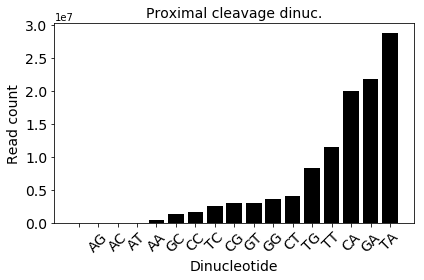

In [6]:
#Plot combined library cut dinucleotides

plot_cut_2mers(library_dict['data'], library_dict['cuts'])


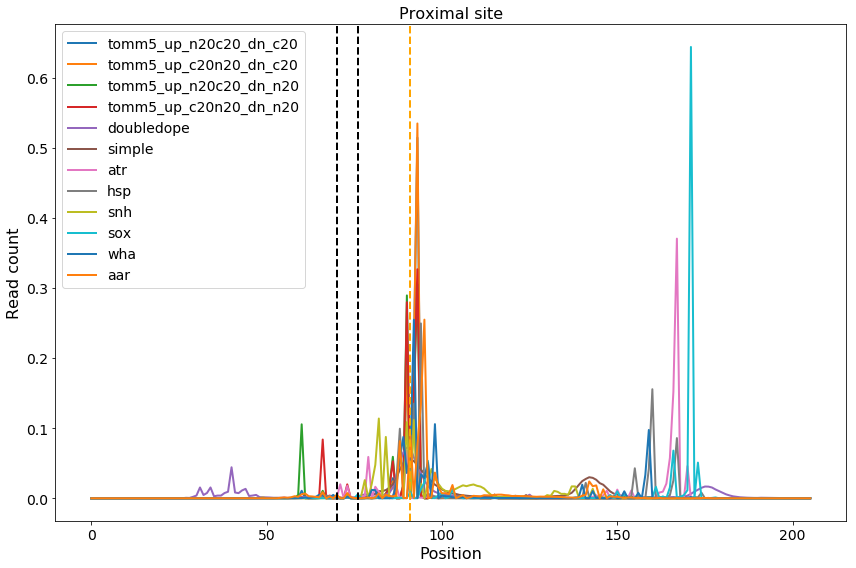

In [7]:
#Plot overlayed cut profiles

f = plt.figure(figsize=(12, 8))

libs = library_dict['data']['library'].unique()

ls = []
for lib in libs :
    
    lib_index = np.nonzero((library_dict['data']['library'] == lib))[0]
    proximal_profile = np.ravel(library_dict['cuts'][lib_index].sum(axis=0))
    proximal_profile /= np.sum(proximal_profile)

    la, = plt.plot(np.arange(len(proximal_profile)), proximal_profile, linewidth=2, label=lib)
    ls.append(la)
    

#Proximal 1
plt.axvline(x=70, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 6, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 21, linewidth=2, c='orange', linestyle='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

plt.legend(handles = ls, fontsize=14)

plt.show()


In [8]:

#Check sublibrary counts in top readcount portion of library

from_fraction = 0.10

libs = library_dict['data']['library'].unique()
total_size = len(library_dict['data'])
for lib in libs :
    lib_slice = library_dict['data'].iloc[-int(from_fraction * total_size):]
    lib_size = len(np.nonzero((lib_slice['library'] == lib))[0])
    
    print('len(' + lib + ') = ' + str(lib_size))


len(tomm5_up_n20c20_dn_c20) = 30266
len(tomm5_up_c20n20_dn_c20) = 30266
len(tomm5_up_n20c20_dn_n20) = 30266
len(tomm5_up_c20n20_dn_n20) = 30267
len(doubledope) = 30267
len(simple) = 30267
len(atr) = 30267
len(hsp) = 30267
len(snh) = 30267
len(sox) = 30267
len(wha) = 30267
len(aar) = 30267


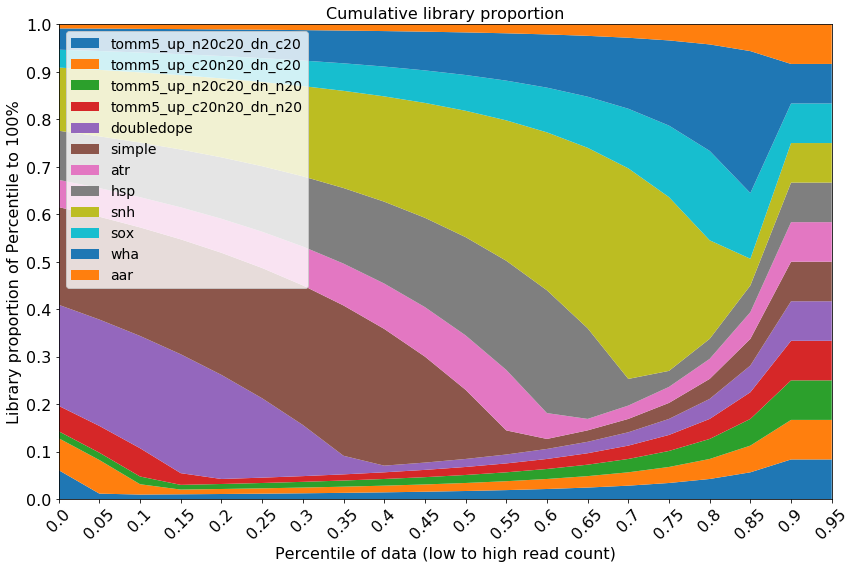

In [9]:
#Plot sublibrary cumulative proportions

library_fractions_from_top = np.linspace(0, 1, num=21)[1:]
libs = library_dict['data']['library'].unique()

cum_fraction = np.zeros((len(library_fractions_from_top), len(libs)))

total_lib_size = float(len(library_dict['data']))

frac_i = 0
for library_fraction in library_fractions_from_top :
    
    lib_i = 0
    for lib in libs :
        lib_slice = library_dict['data'].iloc[-int(library_fraction * total_lib_size):]
        
        lib_size = len(np.nonzero((lib_slice['library'] == lib))[0])
        
        curr_frac = float(lib_size) / float(len(lib_slice))
        
        cum_fraction[frac_i, lib_i] = curr_frac
        
        lib_i += 1
    
    frac_i += 1


fig = plt.subplots(figsize=(12, 8))

plt.stackplot(library_fractions_from_top, np.fliplr(cum_fraction.T), labels=libs)
plt.legend(loc='upper left', fontsize=14)

plt.xticks(library_fractions_from_top, np.flip(np.round(1.0 - library_fractions_from_top, 2), axis=0), fontsize=16, rotation=45)
plt.yticks(np.linspace(0, 1, num=10 + 1), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16)

plt.xlim(np.min(library_fractions_from_top), np.max(library_fractions_from_top))
plt.ylim(0, 1)

plt.xlabel('Percentile of data (low to high read count)', fontsize=16)
plt.ylabel('Library proportion of Percentile to 100%', fontsize=16)

plt.title('Cumulative library proportion', fontsize=16)

plt.tight_layout()
plt.show()

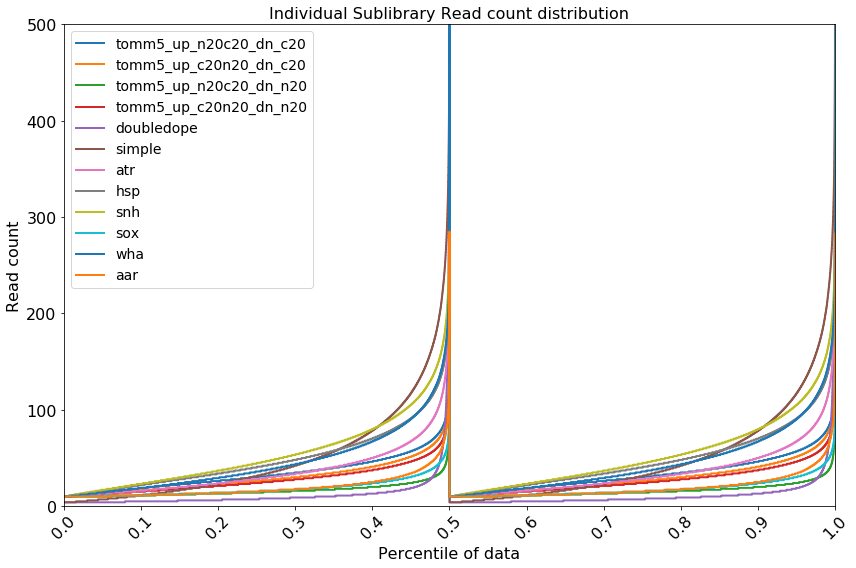

In [26]:

total_count = np.ravel(library_dict['data']['total_count'].values)

lib_frac = np.arange(total_count.shape[0]) / float(total_count.shape[0])

libs = library_dict['data']['library'].unique()

fig = plt.figure(figsize = (12, 8))
ls = []

for lib in libs :
    lib_index = np.nonzero(library_dict['data']['library'] == lib)[0]
    lib_slice = library_dict['data'].iloc[lib_index]
    
    lib_count = np.ravel(lib_slice['total_count'].values)
    lib_frac = np.arange(len(lib_slice)) / float(len(lib_slice))
    
    lt, = plt.plot(lib_frac, lib_count, linewidth=2, label=lib)
    ls.append(lt)

plt.legend(handles=ls, loc='upper left', fontsize=14)

plt.xticks(np.round(np.linspace(0, 1, num=10 + 1), 2), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.xlim(0, 1)
plt.ylim(0, 500)

plt.xlabel('Percentile of data', fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.title('Individual Sublibrary Read count distribution', fontsize=16)

plt.tight_layout()
plt.show()



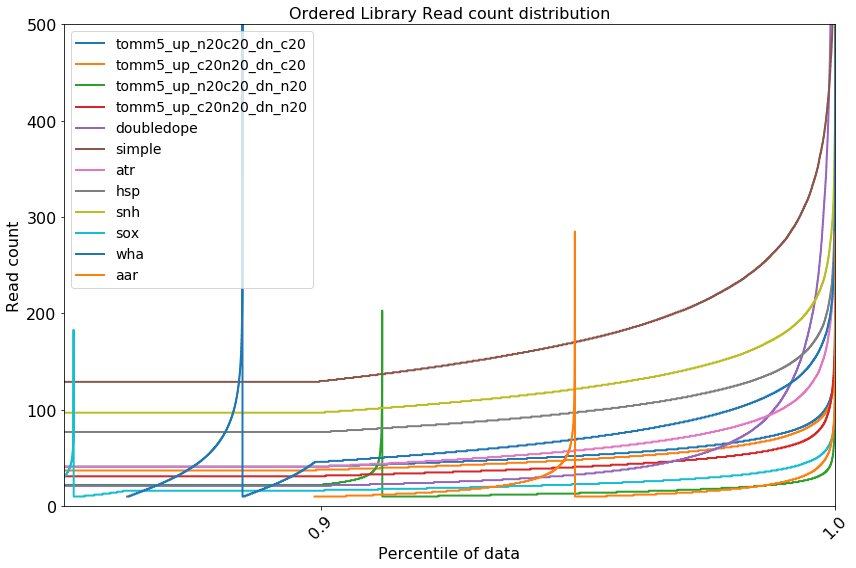

In [25]:

total_count = np.ravel(library_dict['data']['total_count'].values)

total_lib_frac = np.arange(total_count.shape[0]) / float(total_count.shape[0])

libs = library_dict['data']['library'].unique()

fig = plt.figure(figsize = (12, 8))
ls = []

for lib in libs :
    lib_index = np.nonzero(library_dict['data']['library'] == lib)[0]
    lib_slice = library_dict['data'].iloc[lib_index]
    
    lib_count = np.ravel(lib_slice['total_count'].values)
    lib_frac = total_lib_frac[lib_index]
    
    lt, = plt.plot(lib_frac, lib_count, linewidth=2, label=lib)
    ls.append(lt)

plt.legend(handles=ls, loc='upper left', fontsize=14)

plt.xticks(np.round(np.linspace(0, 1, num=10 + 1), 2), np.round(np.linspace(0, 1, num=10 + 1), 2), fontsize=16, rotation=45)
plt.yticks(fontsize=16)

plt.xlim(0.85, 1)
plt.ylim(0, 500)

plt.xlabel('Percentile of data', fontsize=16)
plt.ylabel('Read count', fontsize=16)

plt.title('Ordered Library Read count distribution', fontsize=16)

plt.tight_layout()
plt.show()

